# Проект: классификация

In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [179]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [180]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [181]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

### Задание 3

In [182]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
# ваш код
df['balance'] = df['balance'].apply(lambda x: x.replace("$", "").replace(" ", "").replace(",00", "") if not pd.isna(x) else x)
df['balance'] = df['balance'].astype('float')
print('среднее значение по преобразованному в корректный вид признаку balance ', round(df['balance'].mean(),3))

среднее значение по преобразованному в корректный вид признаку balance  1529.129


### Задание 4

In [183]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код
balance_median = df['balance'].median()
df['balance'] = df['balance'].apply(lambda x: balance_median if pd.isna(x) else x)
print('среднее значение по преобразованному в корректный вид признаку balance ', round(df['balance'].mean(),3))

среднее значение по преобразованному в корректный вид признаку balance  1526.936


### Задание 5

In [184]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
# определяем модальные значения
job_mode = df['job'].mode()[0]
education_mode = df['education'].mode()[0]
# заполняем пропуски модальными значениями
df['job'] = df['job'].apply(lambda x: job_mode if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: education_mode if x == 'unknown' else x)
# рассчитываем средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования
print('средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования ', round(df[(df['job'] == job_mode) & (df['education'] == education_mode)]['balance'].mean(),3))

средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования  1598.883


### Задание 6

In [185]:
# определяем нижнюю и верхнюю границу поиска выбросов по методу Тьюки
x = df['balance']
quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
iqr = quartile_3 - quartile_1
lower_bound = quartile_1 - (iqr * 1.5)
upper_bound = quartile_3 + (iqr * 1.5)
print('Нижняя граница ',round(lower_bound))
print('Верхняя граница ',round(upper_bound))

Нижняя граница  -2241
Верхняя граница  4063


In [186]:
# фильтруем выбросы и считаем объекты
cleaned_df = df[(x>=lower_bound) & (x<=upper_bound)]
print('объектов осталось после удаления всех выбросов ', cleaned_df.shape[0])

объектов осталось после удаления всех выбросов  10105


## Часть 2:  Разведывательный анализ

### Задание 1

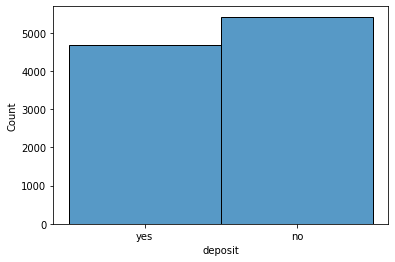

In [187]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
fig = sns.histplot(cleaned_df['deposit'])

Вывод: данные сбалансированы

In [188]:
print('Число клиентов, открыли депозит ', cleaned_df[cleaned_df['deposit'] == 'yes'].shape[0])

Число клиентов, открыли депозит  4681


### Задания 2 и 3

In [189]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код
cleaned_df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


### Задания 4 и 5

In [190]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
cleaned_df.describe(include=[object])

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


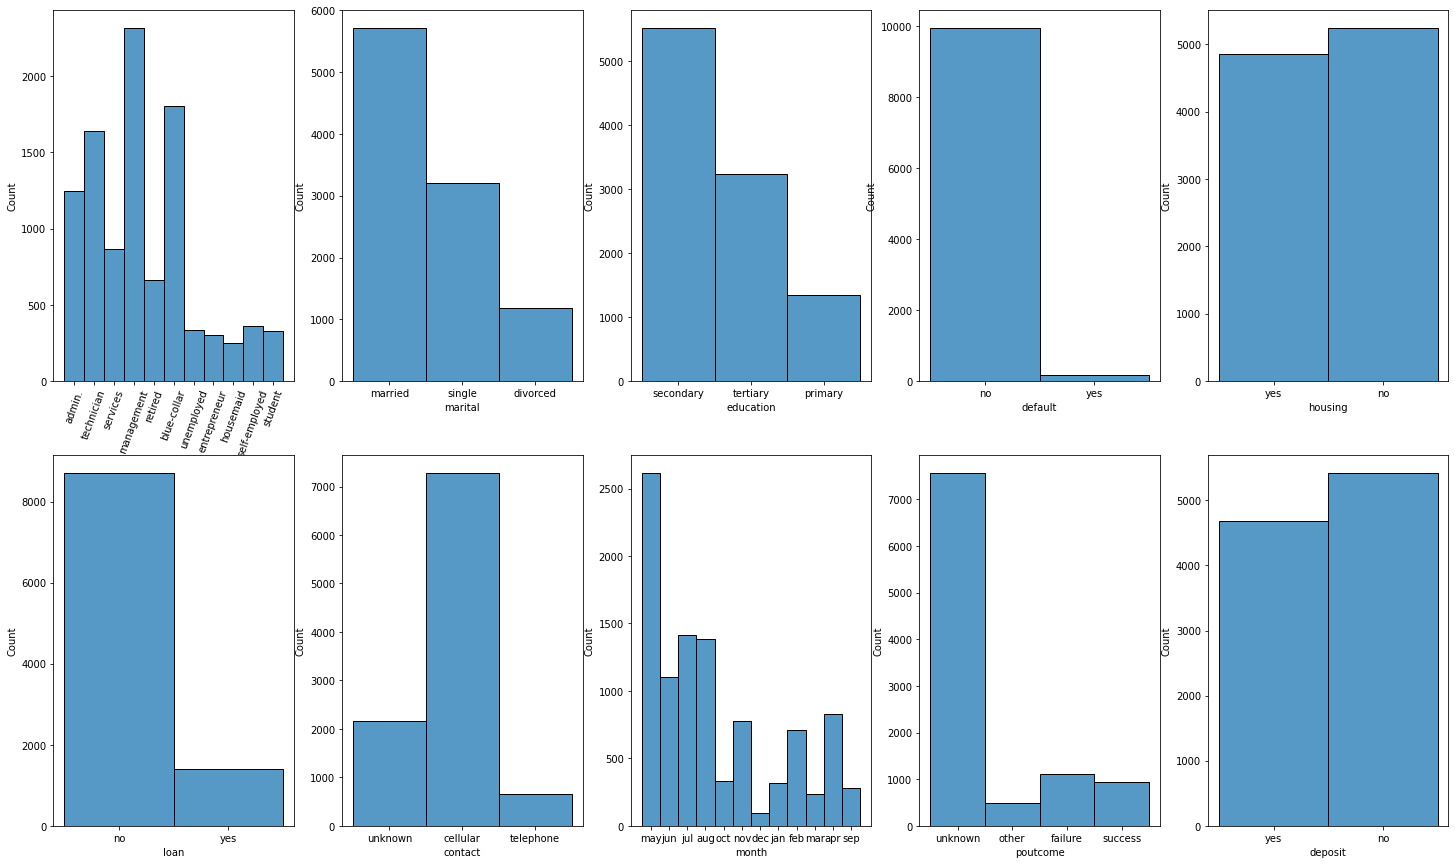

In [191]:
#постройте визуализации, иллюстрирующие результаты
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 15))
hist1 = sns.histplot(data=cleaned_df['job'], ax = axes[0,0])
hist1.tick_params(axis='x', rotation=70);
hist2 = sns.histplot(data=cleaned_df['marital'], ax = axes[0,1])
hist3 = sns.histplot(data=cleaned_df['education'], ax = axes[0,2])
hist4 = sns.histplot(data=cleaned_df['default'], ax = axes[0,3])
hist5 = sns.histplot(data=cleaned_df['housing'], ax = axes[0,4])
hist5 = sns.histplot(data=cleaned_df['loan'], ax = axes[1,0])
hist6 = sns.histplot(data=cleaned_df['contact'], ax = axes[1,1])
hist7 = sns.histplot(data=cleaned_df['month'], ax = axes[1,2])
hist8 = sns.histplot(data=cleaned_df['poutcome'], ax = axes[1,3])
hist9 = sns.histplot(data=cleaned_df['deposit'], ax = axes[1,4])

### Задание 6

In [192]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код
cleaned_df.groupby(['poutcome'])['deposit'].value_counts()

poutcome  deposit
failure   no          562
          yes         547
other     yes         265
          no          216
success   yes         861
          no           84
unknown   no         4562
          yes        3008
Name: deposit, dtype: int64

### Задание 7

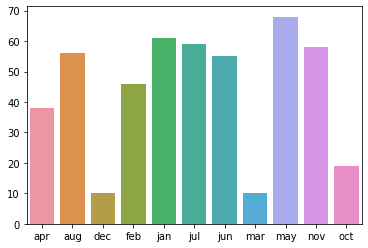

In [193]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код
# считаем положительные и отрицательные результаты помесячно
dd_yes = cleaned_df[cleaned_df['deposit'] == 'yes'].groupby(['month'])['age'].count()
dd_no = cleaned_df[cleaned_df['deposit'] == 'no'].groupby(['month'])['age'].count()
# посчитаем долю отказавшихся помесячно
success_month_percent = {}
for i in range(11):
       key = dd_yes.index[i]
       success_month_percent[key] = round((dd_no[i] / (dd_yes[i] + dd_no[i])) * 100 )
# посмотрим результаты на графике
hist = sns.barplot( x=list(success_month_percent.keys()),
                     y=list(success_month_percent.values())
                 )

### Задание 8

In [194]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
def age_group_definition(age): # функция для определения возрастной группы
    if age < 30:
        return 1
    elif age < 40:
        return 2
    elif age < 50:
        return 3
    elif age < 60:
        return 4
    else:
        return 5
# обработаем столбец возраст
cleaned_df['age_gr'] = cleaned_df['age'].apply(lambda x: age_group_definition(x))

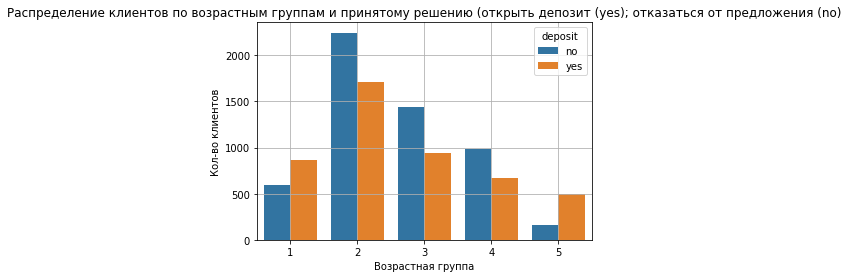

In [195]:
# строим график
gr_data = cleaned_df.groupby(by=['age_gr','deposit'], as_index=False).count()
bar = sns.barplot(
    data = gr_data,
    x = 'age_gr',
    y = 'age',
    hue = 'deposit'
)
bar.set_title('Распределение клиентов по возрастным группам и принятому решению (открыть депозит (yes); отказаться от предложения (no)')
bar.set_xlabel('Возрастная группа')
bar.set_ylabel('Кол-во клиентов')
bar.grid()

### Задания 9 и 10

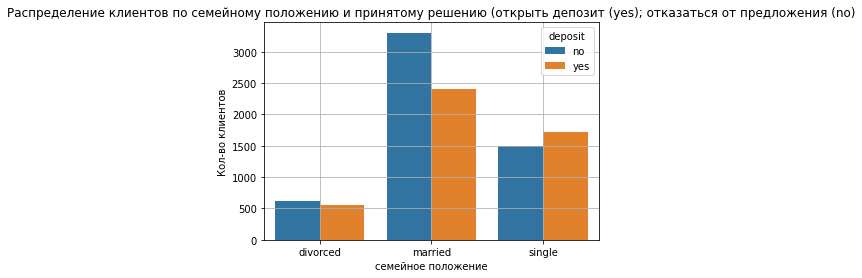

In [196]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
gr_data = cleaned_df.groupby(by=['marital','deposit'], as_index=False).count()
bar = sns.barplot(
    data = gr_data,
    x = 'marital',
    y = 'age',
    hue = 'deposit'
)
bar.set_title('Распределение клиентов по семейному положению и принятому решению (открыть депозит (yes); отказаться от предложения (no)')
bar.set_xlabel('семейное положение')
bar.set_ylabel('Кол-во клиентов')
bar.grid()

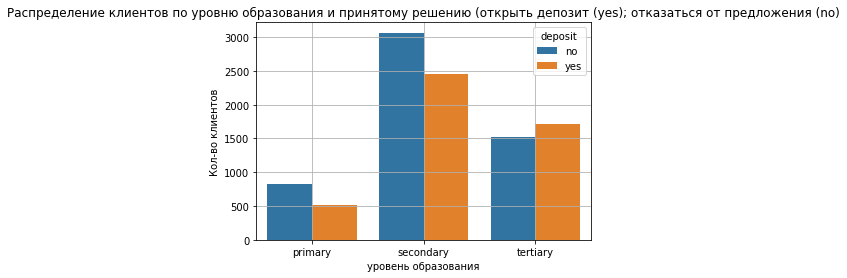

In [197]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
gr_data = cleaned_df.groupby(by=['education','deposit'], as_index=False).count()
bar = sns.barplot(
    data = gr_data,
    x = 'education',
    y = 'age',
    hue = 'deposit'
)
bar.set_title('Распределение клиентов по уровню образования и принятому решению (открыть депозит (yes); отказаться от предложения (no)')
bar.set_xlabel('уровень образования')
bar.set_ylabel('Кол-во клиентов')
bar.grid()

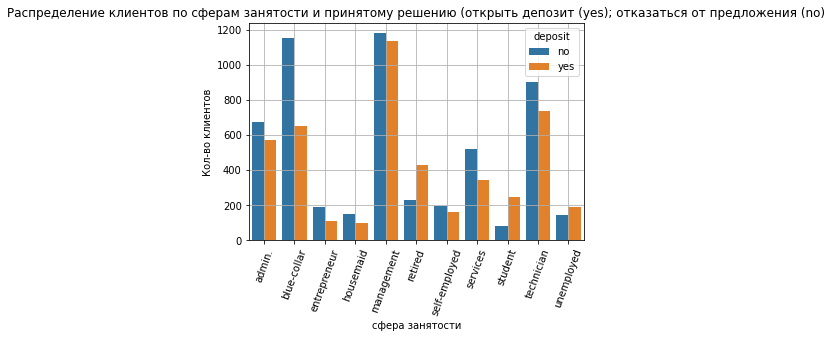

In [198]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
gr_data = cleaned_df.groupby(by=['job','deposit'], as_index=False).count()
bar = sns.barplot(
    data = gr_data,
    x = 'job',
    y = 'age',
    hue = 'deposit'
)
bar.set_title('Распределение клиентов по сферам занятости и принятому решению (открыть депозит (yes); отказаться от предложения (no)')
bar.tick_params(axis='x', rotation=70)
bar.set_xlabel('сфера занятости')
bar.set_ylabel('Кол-во клиентов')
bar.grid()

### Задание 11

In [199]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
# разбиваем датасет на 2 части
df_yes = cleaned_df[cleaned_df['deposit'] == 'yes']
df_no = cleaned_df[cleaned_df['deposit'] == 'no']
# строим сводную таблицу
pivot1 = df_yes.pivot_table(
    values='age_gr',
    columns='education',
    index='marital',
    aggfunc='count'
)
display(pivot1)

education,primary,secondary,tertiary
marital,,,
divorced,96,283,174
married,339,1289,784
single,82,879,755


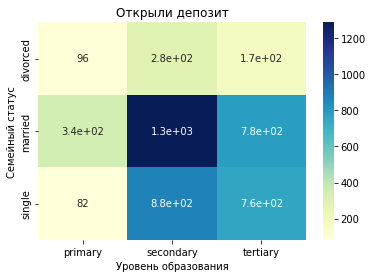

In [200]:
# строим график
heatmap1 = sns.heatmap(data=pivot1, cmap='YlGnBu', annot=True)
heatmap1.set_title('Открыли депозит', fontsize=12)
heatmap1.set_xlabel('Уровень образования')
heatmap1.set_ylabel('Семейный статус');

## Часть 3: преобразование данных

### Задание 1

In [201]:
# преобразуйте уровни образования
le = preprocessing.LabelEncoder()
cleaned_df['education'] = le.fit_transform(cleaned_df['education'])
print('сумму получившихся значений для признака education', cleaned_df['education'].sum())

сумму получившихся значений для признака education 11995


### Задания 2 и 3

In [202]:
# преобразуйте бинарные переменные в представление из нулей и единиц
cleaned_df['deposit'] = le.fit_transform(cleaned_df['deposit'])
print('стандартное отклонение по преобразованной в корректный вид целевой переменной deposit', round(cleaned_df['deposit'].std(),3))

стандартное отклонение по преобразованной в корректный вид целевой переменной deposit 0.499


In [203]:
cleaned_df['default'] = le.fit_transform(cleaned_df['default'])
cleaned_df['housing'] = le.fit_transform(cleaned_df['housing'])
cleaned_df['loan'] = le.fit_transform(cleaned_df['loan'])
print( 'сумма средних арифметических каждой из получившихся переменных', round(cleaned_df['default'].mean() + cleaned_df['housing'].mean() + cleaned_df['loan'].mean(), 3 ))

сумма средних арифметических каждой из получившихся переменных 0.635


### Задание 4

In [204]:
# создайте дамми-переменные
categorical_columns_names = ['job','marital','contact','month','poutcome']
df = pd.get_dummies(cleaned_df, columns = categorical_columns_names)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   education          10105 non-null  int32  
 2   default            10105 non-null  int32  
 3   balance            10105 non-null  float64
 4   housing            10105 non-null  int32  
 5   loan               10105 non-null  int32  
 6   day                10105 non-null  int64  
 7   duration           10105 non-null  int64  
 8   campaign           10105 non-null  int64  
 9   pdays              10105 non-null  int64  
 10  previous           10105 non-null  int64  
 11  deposit            10105 non-null  int32  
 12  age_gr             10105 non-null  int64  
 13  job_admin.         10105 non-null  uint8  
 14  job_blue-collar    10105 non-null  uint8  
 15  job_entrepreneur   10105 non-null  uint8  
 16  job_housemaid      101

### Задания 5 и 6

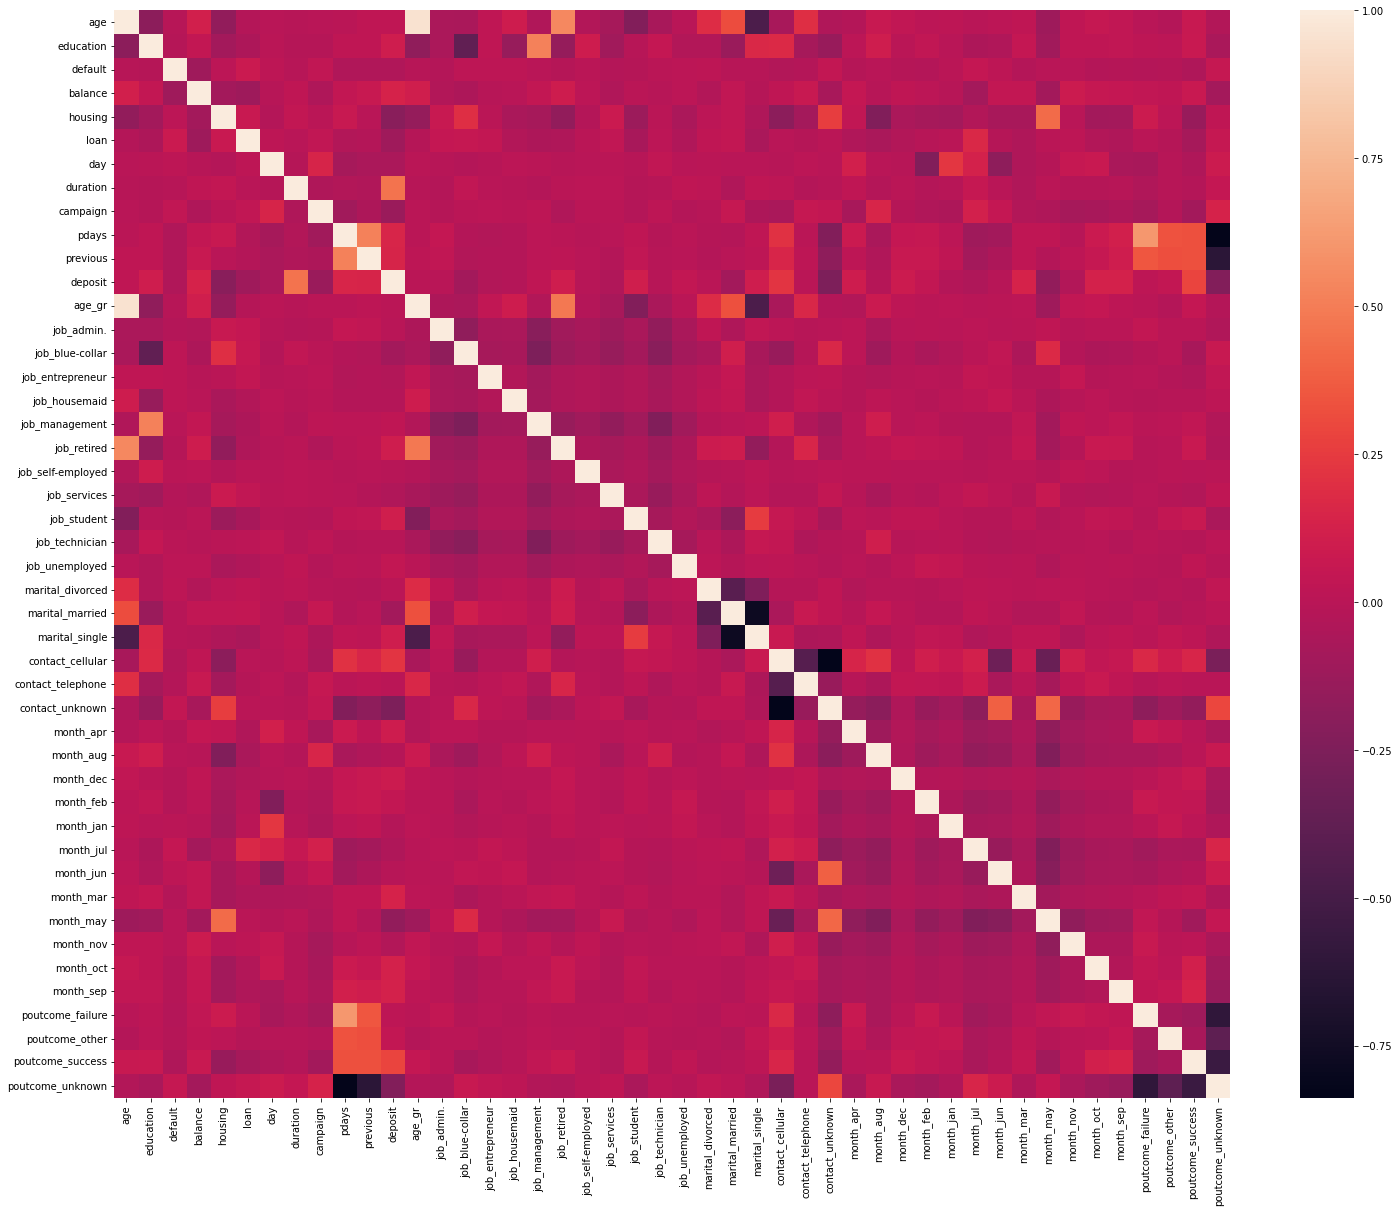

In [205]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
corr_df = df.corr()
# строим тепловую карту для матрицы коллинеарности
fig = plt.subplots(nrows=1, ncols=1, figsize=(25,20))
heatmap = sns.heatmap(corr_df)

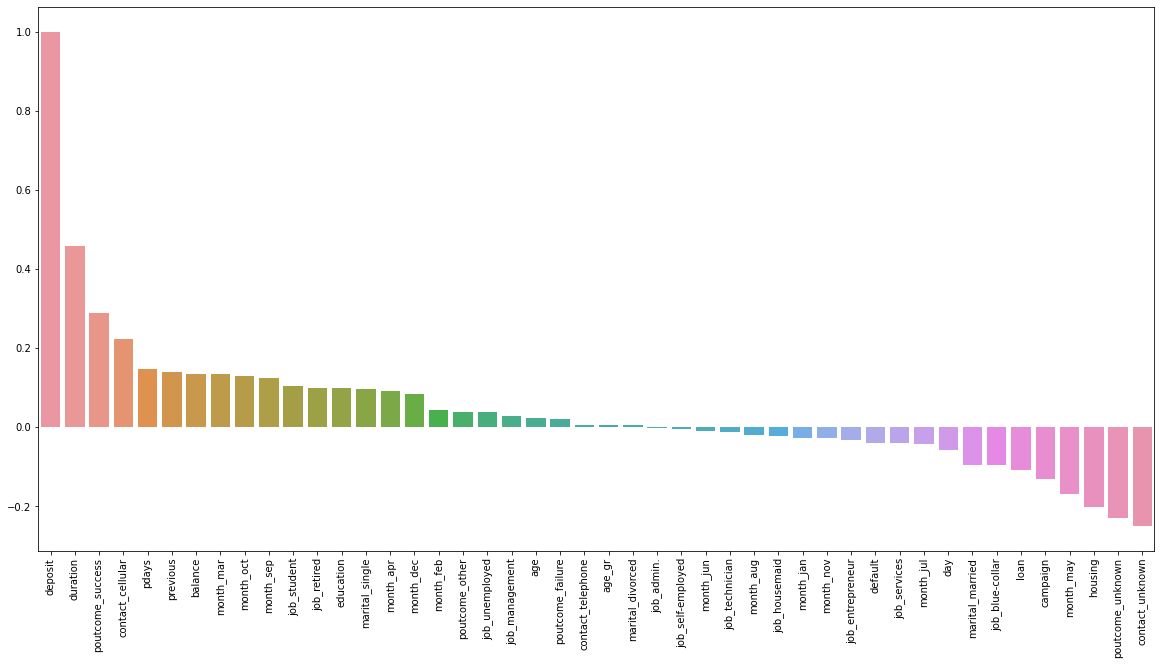

In [206]:
# строим столбчатую диаграмму для ранжированных коэффициентов корреляции
fig = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
bar1 = sns.barplot(
             x = list(corr_df['deposit'].sort_values(ascending=False).keys()),
             y = list(corr_df['deposit'].sort_values(ascending=False)),

            )
bar1.tick_params(axis='x', rotation=90);

### Задания 7 и 8

In [166]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [167]:
# рассчитайте необходимые показатели
print('размер тестовой выборки ', X_test.shape[0])
print('среднее значение целевой переменной на тестовой выборке ', round(y_test.mean(),2))

размер тестовой выборки  3335
среднее значение целевой переменной на тестовой выборке  0.46


### Задание 9

In [175]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(f_classif, k=15).fit(X_train, y_train)
col_names = selector.get_feature_names_out()
col_names

array(['balance', 'housing', 'loan', 'duration', 'campaign', 'pdays',
       'previous', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

### Задание 10

In [314]:
# нормализуйте данные с помощью minmaxsxaler
mm_scaler = preprocessing.MinMaxScaler()
X_train_mm = mm_scaler.fit(X_train[col_names])
X_train_mm = mm_scaler.transform(X_train[col_names])
X_test_mm = mm_scaler.transform(X_test[col_names])

# среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из тестовой выборки
print('среднее арифметическое для первого предиктора из тестовой выборки', round(X_test_mm[:,0].mean(),2))

среднее арифметическое для первого предиктора из тестовой выборки 0.47


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [315]:
# обучите логистическую регрессию и рассчитайте метрики качества
#Создаем объект класса логистическая регрессия
lr = linear_model.LogisticRegression(
    solver='sag', 
    random_state=42, 
    max_iter=1000
    )
#Обучаем модель
lr.fit(X_train_mm, y_train)
#Делаем предсказание класса
y_pred = lr.predict(X_test_mm)

print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_pred)))
#Рассчитываем precision

Accuracy: 0.80


In [316]:
#Делаем предсказание для тренировочной выборки
y_train_pred = lr.predict(X_train_mm)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
#Делаем предсказание для тестовой выборки
y_test_pred = lr.predict(X_test_mm)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      3634
           1       0.84      0.76      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.82      0.82      0.82      6770
weighted avg       0.82      0.82      0.82      6770

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.73      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.81      0.80      0.80      3335



### Задания 2,3,4

In [317]:
# обучите решающие деревья, настройте максимальную глубину
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=8,
    random_state=42
)
#Обучаем дерево по алгоритму CART
dt.fit(X_train_mm, y_train)
#Выводим значения метрики 
y_train_pred = dt.predict(X_train_mm)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = dt.predict(X_test_mm)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 0.82
Test: 0.80


### Задание 5

In [308]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV

param_grid = {'min_samples_split': [2, 5, 7, 10],
              'max_depth': [3,4,5,6,7,8,9,10],
              }
grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(
        random_state=42,
        criterion='entropy'
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search.fit(X_train_mm, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test_mm, y_test)))
y_test_pred = grid_search.predict(X_test_mm)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: total: 781 ms
Wall time: 8.6 s
accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'max_depth': 9, 'min_samples_split': 5}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [319]:
# обучите на ваших данных случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators = 100,
    criterion = 'gini',
    min_samples_leaf = 5,
    max_depth = 10,
    random_state=42
    )

#Обучаем модель
rf.fit(X_train_mm, y_train)
#Выводим значения метрик
y_test_pred = rf.predict(X_test_mm)
print('Accuracy: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('Recall: {:.3f}'.format(metrics.recall_score(y_test, y_test_pred)))

Accuracy: 0.827
Recall: 0.830


### Задания 2 и 3

In [321]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(
    max_depth=5,
    learning_rate = 0.05,
    n_estimators=300,
    min_samples_leaf = 5,
    random_state=42 
)
gb.fit(X_train_mm, y_train)
#Выводим значения метрик
y_test_pred = rf.predict(X_test_mm)
print('F1 score: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

F1 score: 0.82


### Задание 4

In [ ]:
# объедините уже известные вам алгоритмы с помощью стекинга 

### Задание 5

In [ ]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

### Задания 6,7,8

In [ ]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna